In [ ]:
!git clone https://github.com/eilamshapira/HumanChoicePrediction

Cloning into 'HumanChoicePrediction'...
remote: Enumerating objects: 1210, done.
remote: Counting objects: 100% (70/70), done.
remote: Compressing objects: 100% (35/35), done.
remote: Total 1210 (delta 43), reused 44 (delta 35), pack-reused 1140
Receiving objects: 100% (1210/1210), 7.50 MiB | 14.83 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [ ]:
pip install transformers datasets pandas matplotlib


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 3.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 13.2 MB/s eta 0:00:00


**extracting stratigies**

In [ ]:
import ast
import json
import re

def extract_docstrings(filename):
    with open(filename, "r") as file:
        tree = ast.parse(file.read())

    strategies = {}
    for node in ast.walk(tree):
        if isinstance(node, ast.FunctionDef) and node.name.startswith("strategy_"):
            docstring = ast.get_docstring(node)
            if docstring:
                strategy_id = int(node.name.split("_")[1])
                cleaned_docstring = re.sub(r'\(.*\)', '', docstring).strip()
                strategies[strategy_id] = cleaned_docstring

    return strategies

def save_to_json(data, filename):
    with open(filename, "w") as file:
        json.dump(data, file, indent=4)

# Usage
strategies = extract_docstrings("HumanChoicePrediction/Simulation/strategies_code.py")
save_to_json(strategies, "strategies.json")
# Load the JSON file containing the strategy explanations
with open("strategies.json", "r") as file:
    strategies = json.load(file)

In [ ]:
import os
import pandas as pd
# Read the games_clean.csv file into a DataFrame
train = pd.read_csv('HumanChoicePrediction/data/games_clean_X.csv')
test = pd.read_csv('HumanChoicePrediction/data/games_clean_Y.csv')
display(test)

,user_id,strategy_id,gameId,roundNum,hotelId,reviewId,hotelScore,didGo,didWin,correctAnswers,...,bot_points,last_didGo_True,last_last_didGo_True,last_didGo_False,last_last_didGo_False,last_didWin_True,last_last_didWin_True,last_didWin_False,last_last_didWin_False,last_reaction_time
0,0,132,0,1,83,16154,9.157143,True,True,1,...,0,False,False,False,False,False,False,False,False,-1
1,0,132,0,2,568,5683,8.114286,True,True,2,...,1,True,False,False,False,True,False,False,False,20667
2,0,132,0,3,128,2591,10.000000,True,True,3,...,2,True,True,False,False,True,True,False,False,5227
3,0,132,0,4,349,6159,7.257143,False,True,4,...,3,True,True,False,False,True,True,False,False,23809
4,0,132,0,5,329,24538,6.985714,True,False,4,...,3,False,True,True,False,True,True,False,False,29973
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15620,34,93,164,6,553,2158,9.000000,True,True,4,...,5,True,True,False,False,False,True,True,False,135
15621,34,93,164,7,730,3397,5.414286,True,False,4,...,6,True,True,False,False,True,False,False,True,139
15622,34,93,164,8,418,14441,9.171429,True,True,5,...,7,True,True,False,False,False,True,True,False,136
15623,34,93,164,9,575,7542,8.728572,True,True,6,...,8,True,True,False,False,True,False,False,True,133


In [ ]:
train.columns

Index(['user_id', 'strategy_id', 'gameId', 'roundNum', 'hotelId', 'reviewId',
       'hotelScore', 'didGo', 'didWin', 'correctAnswers', 'reaction_time',
       'user_points', 'bot_points', 'last_didGo_True', 'last_last_didGo_True',
       'last_didGo_False', 'last_last_didGo_False', 'last_didWin_True',
       'last_last_didWin_True', 'last_didWin_False', 'last_last_didWin_False',
       'last_reaction_time'],
      dtype='object')

**tranforming the data**

In [ ]:
# Initialize the new DataFrame

def get_review_content(hotel_id, review_id, base_path="/content/HumanChoicePrediction/data/game_reviews"):
    # Construct the path to the file
    file_path = os.path.join(base_path, f"{hotel_id}.csv")

    if not os.path.exists(file_path):
        raise FileNotFoundError(f"No file found for hotel ID: {hotel_id}")

    # Load the file (assuming no header row)
    reviews_df = pd.read_csv(file_path, header=None)

    # Find the row with the matching reviewId
    review_row = reviews_df[reviews_df[0] == review_id]

    if review_row.empty:
        raise ValueError(f"No matching review found for review ID: {review_id} in hotel ID: {hotel_id}")

    # Extract and return the content from the third column of the matching row
    return str(review_row.iloc[0, 2]) + ' ' + str(review_row.iloc[0, 3])


def process_match(tranformed_df,match_df, attempt_count,user_id,strategy, add_review=True ,base_path="/content/HumanChoicePrediction/data/game_reviews"):
    match_features = {}  # To accumulate features for each round in the match as a dict
    rows_list = []
    strategy_explanation = strategies.get(str(strategy), "No explanation available")
    for index, row in match_df.iterrows():
        # Construct a dict of the desired details for the current round
        current_feature = {
            'hotel score': round(row['hotelScore'],2),
            # 'correct answers in this round': row['correctAnswers'],
            'current reaction time': row['reaction_time'],
            'user points in this round': row['user_points'],
            'bot points in this round': row['bot_points']
        }

        # Store the current round's feature in the match_features dict with the roundNum as the key
        match_features[row['roundNum']] = current_feature

        all_features_list = []
        for round_num, details in match_features.items():
            round_details_str = ', '.join([f"{key}: {value}" for key, value in details.items()])
            round_str = f"round {round_num}: {{{round_details_str}}}"
            all_features_list.append(round_str)

        contextual_sentence = "In this task, players in a mobile game make decisions to select good hotels or avoid bad ones, aiming to achieve a target payoff. Each correct choice earns 1 point, helping the player advance to the next level by reaching the predefined target payoff over 10 rounds, competing against rule-based expert bots."
        # Append only the current round's review to the all_features string
        if add_review:
          review_content = get_review_content(row['hotelId'], row['reviewId'], base_path)
              # Construct the feature string
          all_features = (
              f' review: {review_content}' + ' | '
              f' user ID: {user_id} ' +
              # f'bot ID and explanation: {strategy_explanation} ' +
              ' | '.join(all_features_list) +
              f" | Attempts vs current bot: {attempt_count}  "
          )
        else:
          all_features = contextual_sentence + ' | '.join(all_features_list) + f" | Attempts vs current bot: {attempt_count}"
        # Append to the transformed DataFrame
        rows_list.append({'features': all_features, 'label': row['didGo']})

    new_rows_df = pd.DataFrame(rows_list)
    new_rows_df['label'] = new_rows_df['label'].astype(bool)
    transformed_df = pd.concat([tranformed_df, new_rows_df], ignore_index=True)
    return transformed_df


def transform_df(df):
  # Group by 'user_id', 'strategy_id', and 'gameId' to process each match
  grouped = df.groupby(['user_id', 'strategy_id', 'gameId'])
  attempt_counts = {}  # To keep track of attempts for each agent
  transformed_df = pd.DataFrame(columns=['features', 'label'])
  transformed_df['label'] = transformed_df['label'].astype('bool')
  for name, group in grouped:
      user_id, strategy_id, _ = name
      # Determine the attempt count for the current user and strategy_id
      attempt_count = attempt_counts.get((user_id, strategy_id), 0)
      # Process the match
      transformed_df = process_match(transformed_df, group, attempt_count,user_id, strategy_id);
      attempt_counts[(user_id, strategy_id)] = attempt_count + 1
  transformed_df['label'] = transformed_df['label'].astype(int)
  return transformed_df

# Now, transformed_df contains your processed data


In [ ]:
train_transformed = transform_df(train)
test_transformed = transform_df(test)


**get the max tokens in each dataset**

In [ ]:
import pandas as pd
from datasets import Dataset
from transformers import GPT2Tokenizer
import matplotlib.pyplot as plt

test_dataset = Dataset.from_pandas(test_transformed)
# test_dataset = Dataset.from_pandas(test_df)
dataset = test_dataset
# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')

# Function to count tokens
def count_tokens(examples):
    tokens = tokenizer(examples['features'], truncation=True, padding=False)
    examples['num_tokens'] = [len(t) for t in tokens['input_ids']]
    return examples

# Apply token counting
tokenized_dataset = dataset.map(count_tokens, batched=True)

max_tokens = max(tokenized_dataset['num_tokens'])
print(f"Maximum number of tokens in the dataset: {max_tokens}")


/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/762 [00:00<?, ?B/s]

Map:   0%|          | 0/15625 [00:00<?, ? examples/s]

Maximum number of tokens in the dataset: 551


In [ ]:

train_dataset = Dataset.from_pandas(train_transformed)
dataset = train_dataset
# Load tokenizer
tokenizer = GPT2Tokenizer.from_pretrained('distilgpt2')

# Function to count tokens
def count_tokens(examples):
    tokens = tokenizer(examples['features'], truncation=True, padding=False)
    examples['num_tokens'] = [len(t) for t in tokens['input_ids']]
    return examples

# Apply token counting
tokenized_dataset = dataset.map(count_tokens, batched=True)


max_tokens = max(tokenized_dataset['num_tokens'])
print(f"Maximum number of tokens in the dataset: {max_tokens}")

Map:   0%|          | 0/71579 [00:00<?, ? examples/s]

Maximum number of tokens in the dataset: 565


In [ ]:
train_transformed.to_csv('fineTuning_train_df_only_ef_review.csv')
test_transformed.to_csv('fineTuning_test_df_only_ef_review.csv')

In [ ]:
display(test_transformed)

,features,label
0,"user ID: 0 bot ID and explanation: #17 Is hotel was chosen in last round? if True, [play max]. else, [play mean] round 1: {hotel score: 9.37, current reaction time: 4803, user points in this round: 0, bot points in this round: 0} | Attempts vs current bot: 0",1
1,"user ID: 0 bot ID and explanation: #17 Is hotel was chosen in last round? if True, [play max]. else, [play mean] round 1: {hotel score: 9.37, current reaction time: 4803, user points in this round: 0, bot points in this round: 0} | round 2: {hotel score: 8.17, current reaction time: 35625, user points in this round: 1, bot points in this round: 1} | Attempts vs current bot: 0",1
2,"user ID: 0 bot ID and explanation: #17 Is hotel was chosen in last round? if True, [play max]. else, [play mean] round 1: {hotel score: 9.37, current reaction time: 4803, user points in this round: 0, bot points in this round: 0} | round 2: {hotel score: 8.17, current reaction time: 35625, user points in this round: 1, bot points in this round: 1} | round 3: {hotel score: 9.36, current reaction time: 26535, user points in this round: 2, bot points in this round: 2} | Attempts vs current bot: 0",1
3,"user ID: 0 bot ID and explanation: #17 Is hotel was chosen in last round? if True, [play max]. else, [play mean] round 1: {hotel score: 9.37, current reaction time: 4803, user points in this round: 0, bot points in this round: 0} | round 2: {hotel score: 8.17, current reaction time: 35625, user points in this round: 1, bot points in this round: 1} | round 3: {hotel score: 9.36, current reaction time: 26535, user points in this round: 2, bot points in this round: 2} | round 4: {hotel score: 5.51, current reaction time: 34440, user points in this round: 3, bot points in this round: 3} | Attempts vs current bot: 0",1
4,"user ID: 0 bot ID and explanation: #17 Is hotel was chosen in last round? if True, [play max]. else, [play mean] round 1: {hotel score: 9.37, current reaction time: 4803, user points in this round: 0, bot points in this round: 0} | round 2: {hotel score: 8.17, current reaction time: 35625, user points in this round: 1, bot points in this round: 1} | round 3: {hotel score: 9.36, current reaction time: 26535, user points in this round: 2, bot points in this round: 2} | round 4: {hotel score: 5.51, current reaction time: 34440, user points in this round: 3, bot points in this round: 3} | round 5: {hotel score: 7.37, current reaction time: 4553, user points in this round: 3, bot points in this round: 4} | Attempts vs current bot: 0",1
...,...,...
15620,"user ID: 34 bot ID and explanation: #132 Is hotel score >= 8? if True, [play max]. else, [Is hotel score in the last round >= 8? if True, play min. else, play mean] round 1: {hotel score: 7.43, current reaction time: 2148, user points in this round: 0, bot points in this round: 0} | round 2: {hotel score: 8.47, current reaction time: 192, user points in this round: 1, bot points in this round: 0} | round 3: {hotel score: 9.74, current reaction time: 138, user points in this round: 1, bot points in this round: 0} | round 4: {hotel score: 6.64, current reaction time: 177, user points in this round: 1, bot points in this round: 0} | round 5: {hotel score: 8.94, current reaction time: 150, user points in this round: 2, bot points in this round: 0} | round 6: {hotel score: 9.43, current reaction time: 146, user points in this round: 2, bot points in this round: 0} | Attempts vs current bot: 18",0
15621,"user ID: 34 bot ID and explanation: #132 Is hotel score >= 8? if True, [play max]. else, [Is hotel score in the last round >= 8? if True, play min. else, play mean] round 1: {hotel score: 7.43, current reaction time: 2148, user points in this round: 0, bot points in this round: 0} | round 2: {hotel score: 8.47, current reaction time: 192, user points in this round: 1, bot points in this round: 0} | round 3: {hotel score: 9.74, current reaction time: 138, user points in this round: 1, bot points in this round: 0} | round 4: 

#Vis for Result

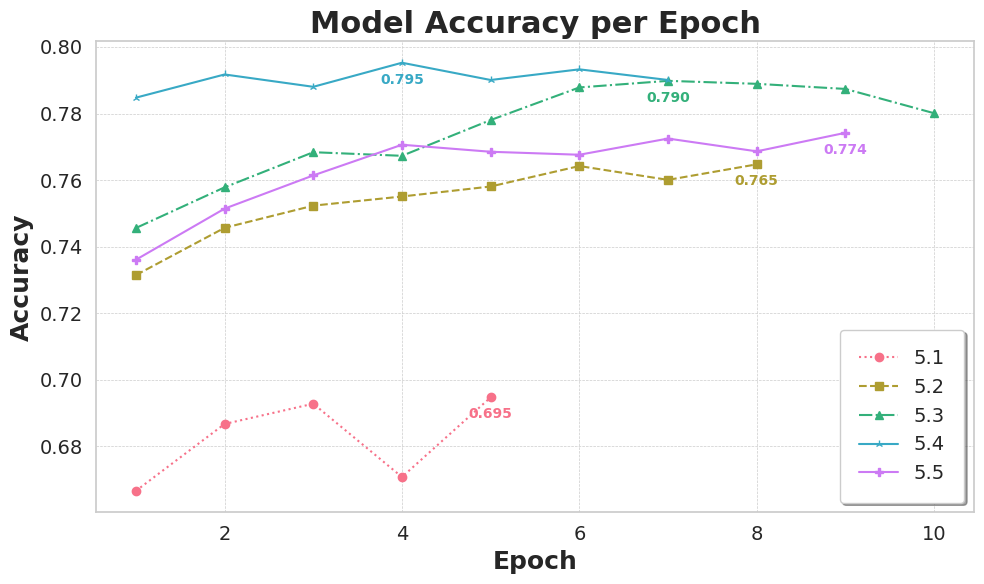

In [ ]:
import json
import matplotlib.pyplot as plt
import seaborn as sns

# Load the JSON data
with open('result_json.json', 'r') as file:
    data = json.load(file)

# Extract the data for each model
model_v1_accuracies = data["5_1"]
model_v2_accuracies = data["5_2"]
model_v3_accuracies = data["5_3"]
model_v4_accuracies = data["5_4"]
model_v5_accuracies = data["5_5"]

# Define the epochs (assuming 1-based indexing for epochs)
epochs_v1 = list(range(1, len(model_v1_accuracies) + 1))
epochs_v2 = list(range(1, len(model_v2_accuracies) + 1))
epochs_v3 = list(range(1, len(model_v3_accuracies) + 1))
epochs_v4 = list(range(1, len(model_v4_accuracies) + 1))
epochs_v5 = list(range(1, len(model_v5_accuracies) + 1))

# Set style
sns.set(style="whitegrid")

# Define color palette
palette = sns.color_palette("husl", 5)  # Use Husl color palette for better differentiation

# Plotting the accuracies
plt.figure(figsize=(10, 6))
plt.plot(epochs_v1, model_v1_accuracies, marker='o', linestyle=':', color=palette[0], label='5.1')
plt.plot(epochs_v2, model_v2_accuracies, marker='s', linestyle='--', color=palette[1], label='5.2')
plt.plot(epochs_v3, model_v3_accuracies, marker='^', linestyle='-.', color=palette[2], label='5.3')
plt.plot(epochs_v4, model_v4_accuracies, marker='2', linestyle='-', color=palette[3], label='5.4')
plt.plot(epochs_v5, model_v5_accuracies, marker='P', linestyle='-', color=palette[4], label='5.5')

# Adding titles and labels
plt.title('Model Accuracy per Epoch', fontsize=22, fontweight='bold')
plt.xlabel('Epoch', fontsize=18, fontweight='bold')
plt.ylabel('Accuracy', fontsize=18, fontweight='bold')
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(fontsize=14, frameon=True, shadow=True, borderpad=1, loc='lower right')



# Customizing grid lines
plt.grid(which='both', linestyle='--', linewidth=0.5)

# Adding annotations to highlight maximal values
def annotate_max(epochs, accuracies, color):
    max_accuracy = max(accuracies)
    max_epoch = accuracies.index(max_accuracy) + 1  # 1-based index
    plt.annotate(f'{max_accuracy:.3f}', (max_epoch, max_accuracy), textcoords="offset points", xytext=(0,-15), ha='center', fontsize=10, fontweight='bold', color=color)

annotate_max(epochs_v1, model_v1_accuracies, palette[0])
annotate_max(epochs_v2, model_v2_accuracies, palette[1])
annotate_max(epochs_v3, model_v3_accuracies, palette[2])
annotate_max(epochs_v4, model_v4_accuracies, palette[3])
annotate_max(epochs_v5, model_v5_accuracies, palette[4])

# Display the plot
plt.tight_layout()
plt.show()
